Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [ ]:
# !pip install numpy
# !pip install geopy
# !pip install pandas
# !pip install matplotlib
# !pip install geopandas

In [ ]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import random
import os
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG)

In [ ]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km
CITIES.head()

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [ ]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

In [ ]:
def plot_tsp(tsp, cities, country):
    """Plot the TSP solution """

    # Extract the coordinates of the cities in the order of the TSP path
    x_coords = [cities.at[city, 'lon'] for city in tsp]
    y_coords = [cities.at[city, 'lat'] for city in tsp]

    plt.figure(figsize=(10, 6))

    # Plot the TSP path
    plt.plot(x_coords, y_coords, 'b-', marker='o', markersize=5, label='TSP Path')
    
    # Add a line connecting the last city to the first one
    plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], 'b-', marker='o', markersize=5)

    # Annotate the cities
    for city in cities.itertuples():
        plt.text(city.lon, city.lat, city.name, fontsize=8)

    # Highlight the start/end city
    plt.plot(x_coords[0], y_coords[0], 'g^', markersize=10, label='Start/End')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('TSP Solution for ' + country)
    plt.grid(True)
    plt.show()

 ## Solution 1
 Fast, but more approximate algorithm: greedy algorithm that always chooses the nearest city.

In [ ]:
def greedy_tsp(dist_matrix, cities):
    city = 0
    tsp = [city]
    visited = np.full(len(cities), False)
    visited[city] = True
    dist = dist_matrix.copy()
    dist[:, city] = np.inf

    while not np.all(visited):  # I need to visit all cities
        dist[:, city] = np.inf  # I can't go back to the same city
        closest = np.argmin(dist[city])  # Find the closest city
        visited[closest] = True  # Mark the city as visited
        city = closest
        tsp.append(int(city))  # Add the city to the path

    tsp.append(tsp[0])  # Return to the starting city

    total_cost = sum(dist_matrix[tsp[i], tsp[i + 1]] for i in range(len(tsp) - 1))
    return tsp, total_cost

In [ ]:
tsp, total_cost = greedy_tsp(DIST_MATRIX, CITIES)

for c1, c2 in zip(tsp, tsp[1:] + [tsp[0]]):
    logging.debug(f"step: {CITIES.at[c1, 'name']} -> {CITIES.at[c2, 'name']} ({DIST_MATRIX[c1, c2]:.2f}km)")

logging.info(f"result: Found a path of {len(tsp) - 1} steps, total length {total_cost:.2f}km")
plot_tsp(tsp, CITIES, 'Italy')

## Solution 2
Slower, but more accurate algorithm: **inver-over crossover**, as suggested by the professor during the lectures.

In [ ]:
def inver_over(tsp, dist_matrix, population_size=100, generations=500, p=0.02):
    def calculate_cost(tour):
        """ Calculate the total cost of a tour """
        # Also consider the cost of returning to the starting city
        return sum(dist_matrix[tour[i], tour[i + 1]] for i in range(len(tour) - 1)) + dist_matrix[tour[-1], tour[0]]

    def invert(tour, i, j):
        """ Invert the order of 2 edges in a tour """
        if i > j:
            i, j = j, i
        return tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]

    n = len(tsp)
    population = [random.sample(tsp, len(tsp)) for _ in range(population_size)]  # Generate the initial population
    best_tour = min(population, key=calculate_cost)
    best_cost = calculate_cost(best_tour)

    for _ in range(generations):
        for tour in population:
            for i in range(n):
                if random.random() < p:  # With probability p, choose a random city (could be the current one)
                    j = random.randint(0, n - 1)
                else:  # Otherwise, choose any city that is not the current one
                    j = random.choice([k for k in range(n) if k != i])

                new_tour = invert(tour, i, j)  # Apply the inversion

                if calculate_cost(new_tour) < calculate_cost(tour):
                    tour[:] = new_tour  # Update the tour if the new one is better

            if calculate_cost(tour) < best_cost:  # Update the best tour if the current one is better
                best_tour = tour[:]
                best_cost = calculate_cost(tour)

    return best_tour, best_cost

In [ ]:
tsp = list(range(len(CITIES)))  # Initial tour, visiting the cities in order
best_tour, best_cost = inver_over(tsp, DIST_MATRIX)

for c1, c2 in zip(best_tour, best_tour[1:] + [best_tour[0]]):
    logging.debug(f"step: {CITIES.at[c1, 'name']} -> {CITIES.at[c2, 'name']} ({DIST_MATRIX[c1, c2]:.2f}km)")
logging.info(f"result: Found a path of {len(best_tour)} steps, total length {best_cost:.2f}km")
plot_tsp(best_tour, CITIES, 'Italy')

### Tests
Test the two solutions on the cities of all countries in the `cities` folder.

INFO:root:Files in cities folder: ['italy.csv', 'russia.csv', 'vanuatu.csv', 'china.csv', 'us.csv']
INFO:root:Processing italy.csv
INFO:root:Greedy: Found a path of 46 steps, total length 4436.03km


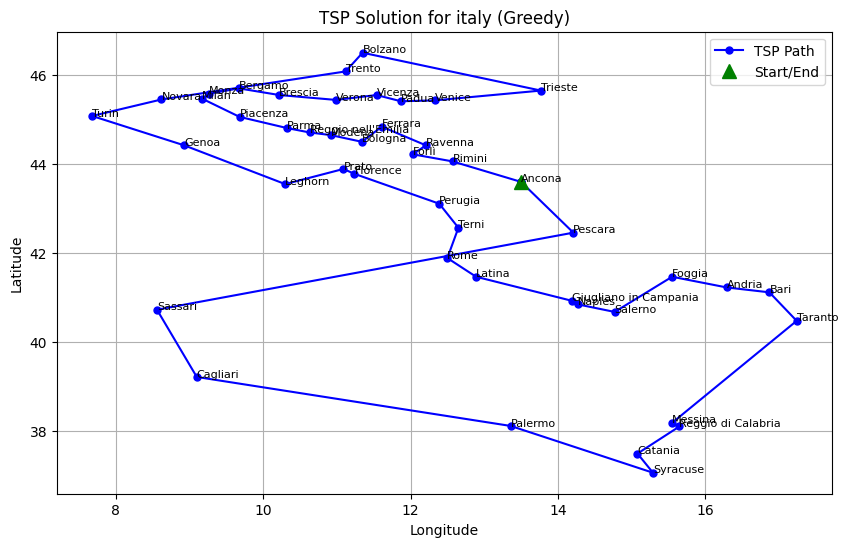

INFO:root:Inver-over: Found a path of 47 steps, total length 4175.23km


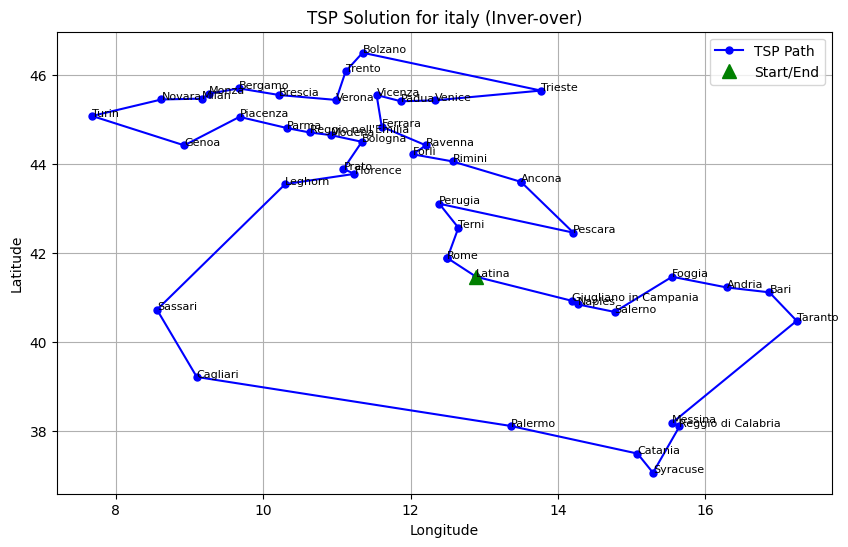

INFO:root:Processing russia.csv
INFO:root:Greedy: Found a path of 167 steps, total length 42334.16km


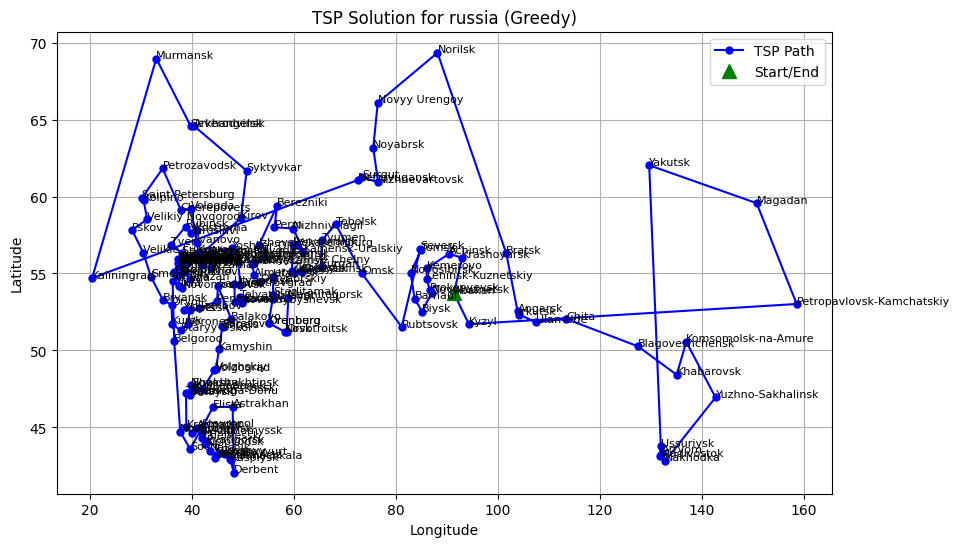

INFO:root:Inver-over: Found a path of 168 steps, total length 33602.44km


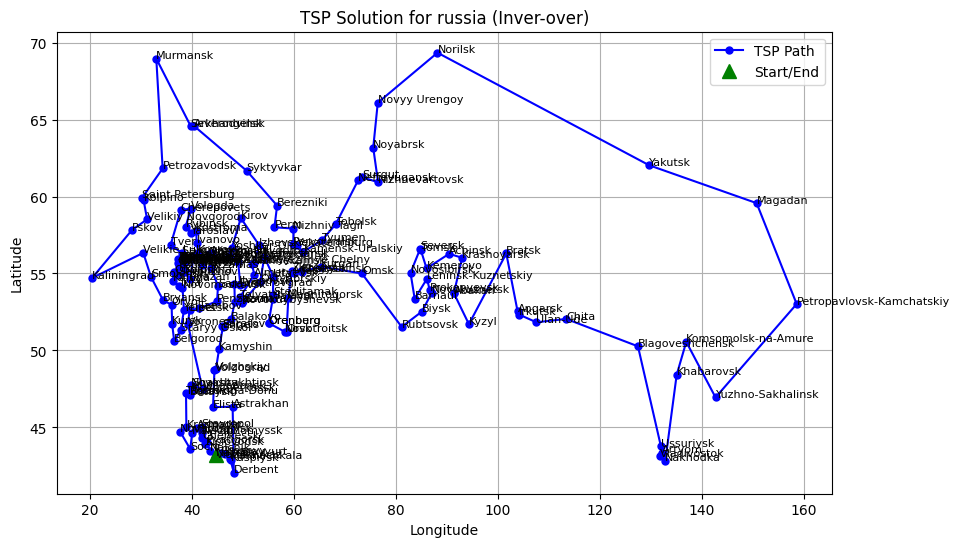

INFO:root:Processing vanuatu.csv
INFO:root:Greedy: Found a path of 8 steps, total length 1475.53km


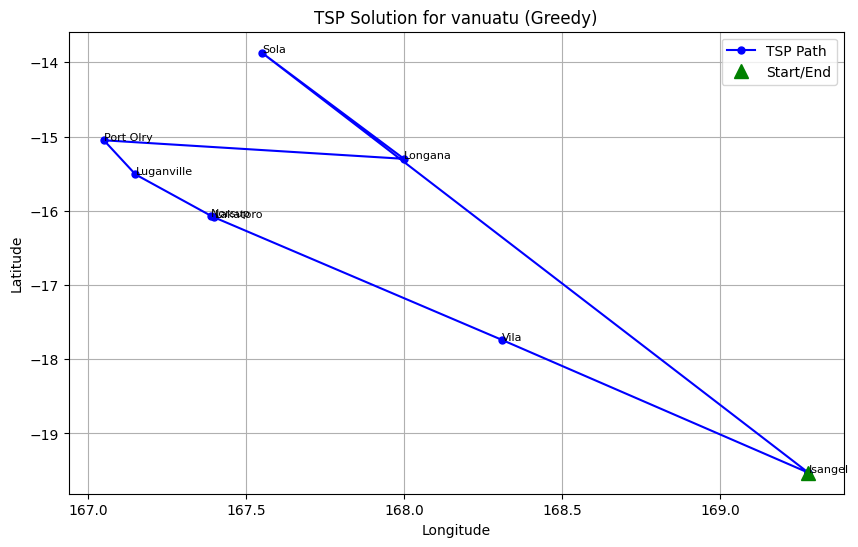

INFO:root:Inver-over: Found a path of 9 steps, total length 1345.54km


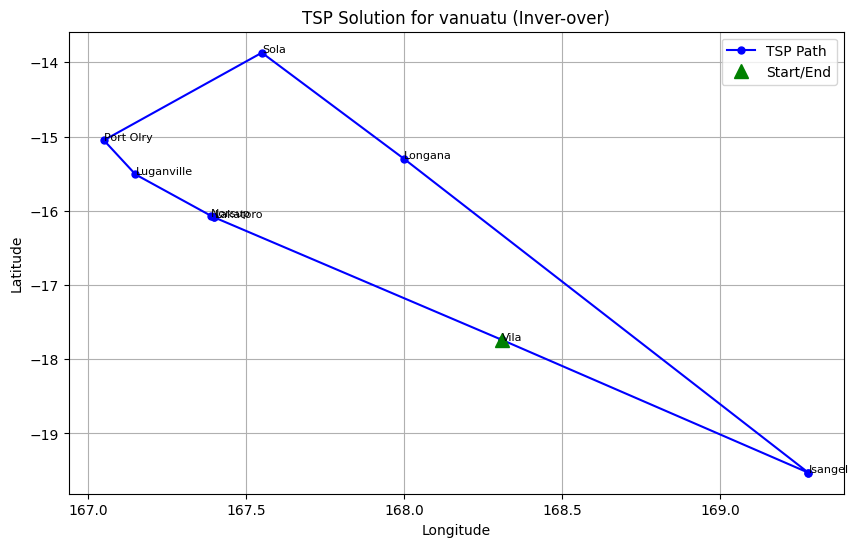

INFO:root:Processing china.csv
INFO:root:Greedy: Found a path of 726 steps, total length 63962.92km


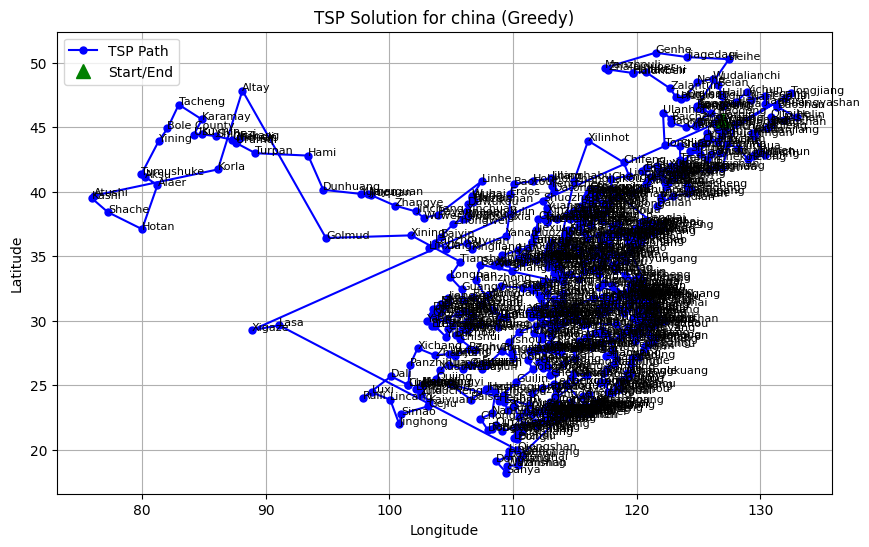

INFO:root:Inver-over: Found a path of 727 steps, total length 63925.54km


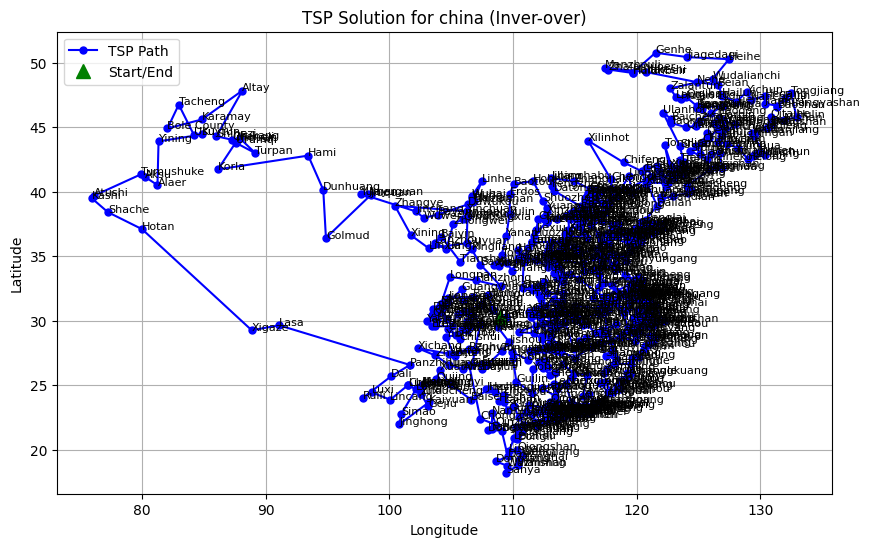

INFO:root:Processing us.csv
INFO:root:Greedy: Found a path of 326 steps, total length 48050.03km


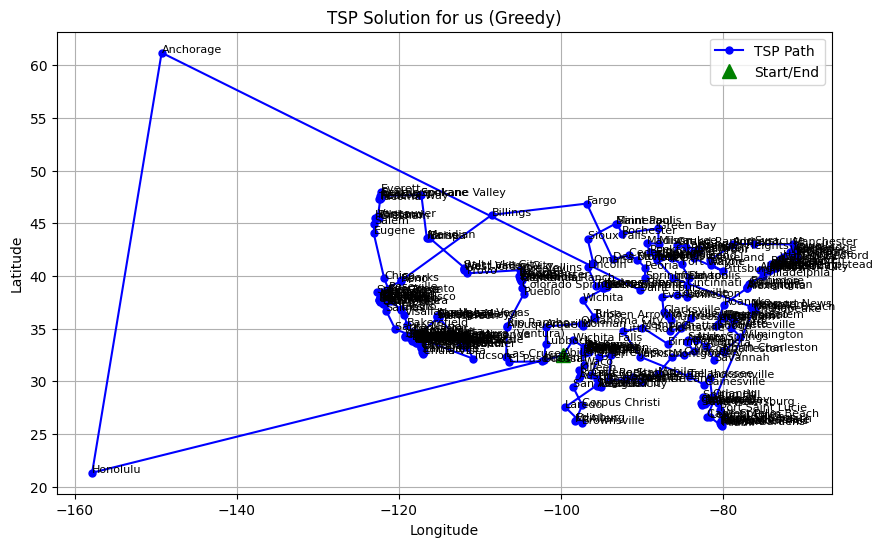

INFO:root:Inver-over: Found a path of 327 steps, total length 41279.01km


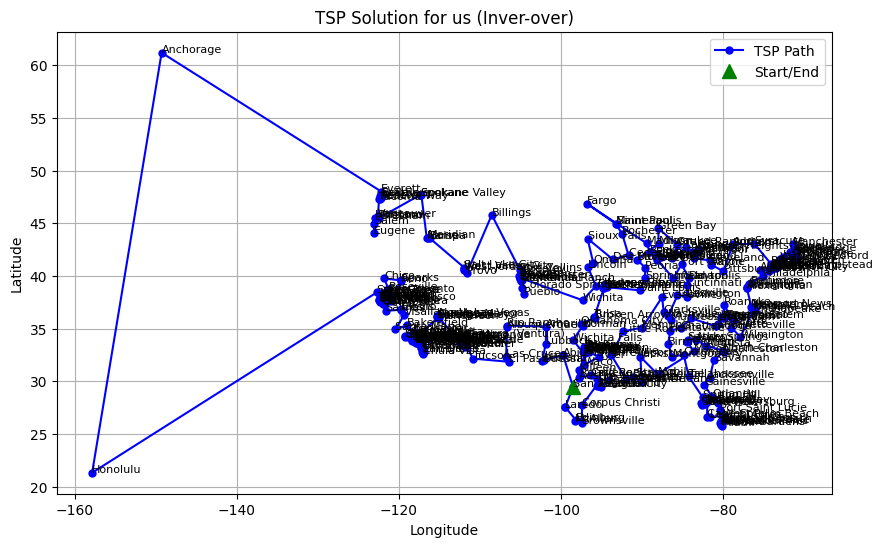

In [13]:
# Load all the countries (one file per country)
logging.info("Files in cities folder: " + str(os.listdir('cities')))
for file_name in os.listdir('cities'):
    logging.info(f"Processing {file_name}")

    # Load the cities and calculate the distance matrix
    CITIES = pd.read_csv(f'cities/{file_name}', header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km

    # Run the greedy algorithm
    tsp, total_cost = greedy_tsp(DIST_MATRIX, CITIES)
    logging.info(f"Greedy: Found a path of {len(tsp)} steps, total length {total_cost:.2f}km")
    plot_tsp(tsp, CITIES, file_name.split('.')[0] + ' (Greedy)')

    # Run the inver-over algorithm, reusing the greedy solution as a starting point
    best_tour, best_cost = inver_over(tsp, DIST_MATRIX)
    logging.info(f"Inver-over: Found a path of {len(best_tour)} steps, total length {best_cost:.2f}km")
    plot_tsp(best_tour, CITIES, file_name.split('.')[0] + ' (Inver-over)')